In [1]:
%pip install --upgrade pip
%pip install transformers torch torchvision
%pip install devinterp
%pip install numpy 

import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu" 
# if you want to use your TPU (note that torch_xla is not by default installed, install using pip install devinterp[tpu]) 
# import os 
# os.environ["USE_TPU_BACKEND"] = "1" 
# import torch_xla.core.xla_model as xm 
# DEVICE = xm.xla_device()

import warnings

import torch
import torchvision
from torch.nn import functional as F
from transformers import AutoModelForImageClassification

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

warnings.filterwarnings("ignore")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


/Users/meerigupta/Downloads/llc-interpretability/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from rasp_models.palindrome import check_palindrome
from tracr.haiku_to_pytorch import haiku_to_pytorch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

bos = "BOS"
init_model = check_palindrome()
base_model = haiku_to_pytorch(init_model)

init_vocab = ['a', 'b', 'c', 'd', 'e']
init_label = lambda data: int(list(data) == list(data)[::-1])
init_seq_len = 5

token_to_idx = init_model.input_encoder.encoding_map
vocab_list = list(token_to_idx.keys())
vocab_size = init_model.input_encoder.vocab_size
d_model = base_model.layers[0].attn.d_model
max_pos = init_model.params['pos_embed']['embeddings'].shape[0]

print(f"Vocab size: {vocab_size}, d_model: {d_model}")

class TracrWithEmbeddings(nn.Module):
    def __init__(self, base_model, vocab_size, d_model, max_pos, token_to_idx, haiku_model):
        super().__init__()
        self.base_model = base_model
        self.token_to_idx = token_to_idx
        self.vocab_size = vocab_size
        
        self.token_embed = nn.Embedding(vocab_size, d_model, dtype=torch.float64)
        self.pos_embed = nn.Embedding(max_pos, d_model, dtype=torch.float64)
        
        with torch.no_grad():
            token_emb_weights = torch.tensor(
                np.array(haiku_model.params['token_embed']['embeddings']),
                dtype=torch.float64
            )
            self.token_embed.weight.copy_(token_emb_weights)
            
            pos_emb_weights = torch.tensor(
                np.array(haiku_model.params['pos_embed']['embeddings']),
                dtype=torch.float64
            )
            self.pos_embed.weight.copy_(pos_emb_weights)
    
    def forward(self, x):
        batch_indices = []
        for seq in x:
            indices = [self.token_to_idx[token] for token in seq]
            batch_indices.append(indices)
        
        x_indices = torch.tensor(batch_indices, dtype=torch.long, device=self.token_embed.weight.device)
        tok_emb = self.token_embed(x_indices)
        pos_emb = self.pos_embed(torch.arange(x_indices.shape[1], device=x_indices.device))
        x = tok_emb + pos_emb
        
        for layer in self.base_model.layers:
            x = layer(x)
        
        return x

base_transformer = TracrWithEmbeddings(base_model, vocab_size, d_model, max_pos, token_to_idx, init_model)
base_transformer = base_transformer.to(DEVICE)

# Use the correct dimension!
PALINDROME_DIM = 331

class TracrPalindromeClassifier(nn.Module):
    """
    Extract palindrome result by checking if ALL positions
    (except BOS) have high values in dimension 331.
    """
    def __init__(self, transformer, palindrome_dim):
        super().__init__()
        self.transformer = transformer
        self.palindrome_dim = palindrome_dim
    
    def forward(self, x):
        hidden = self.transformer(x)  # (batch, seq_len, d_model)
        
        # Get the palindrome indicator for all positions except BOS (position 0)
        palindrome_indicators = hidden[:, 1:, self.palindrome_dim]  # (batch, seq_len-1)
        
        # A sequence is a palindrome if ALL positions have indicator > 0.5
        # Take the minimum value across all positions
        min_indicator = palindrome_indicators.min(dim=1)[0]  # (batch,)
        
        # Convert to logits: if min > 0.5, it's a palindrome
        logits = torch.stack([1.0 - min_indicator, min_indicator], dim=1)
        
        return logits

model = TracrPalindromeClassifier(base_transformer, PALINDROME_DIM)

# Make parameters trainable for LLC
for param in model.parameters():
    param.requires_grad = True

model = model.to(DEVICE)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

# Dataset
class GeneralDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, seq_len, num_samples):
        self.vocab = vocab
        self.seq_len = seq_len
        self.num_samples = num_samples
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        seq = [np.random.choice(self.vocab) for _ in range(self.seq_len)]
        label = init_label(seq)
        full_seq = ["BOS"] + seq
        return full_seq, label

def custom_collate(batch):
    sequences, labels = zip(*batch)
    return list(sequences), torch.tensor(labels, dtype=torch.long)

vocab = init_vocab 
data = GeneralDataset(vocab=vocab, seq_len=init_seq_len, num_samples=10000) 
loader = torch.utils.data.DataLoader(data, batch_size=256, shuffle=True, collate_fn=custom_collate)

def evaluate(model, batch):
    sequences, labels = batch  
    labels = labels.to(DEVICE)
    logits = model(sequences)
    loss = F.cross_entropy(logits, labels)
    return loss

# Test accuracy
print("\n=== Testing Model Accuracy (should be ~100%) ===")
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in loader:
        sequences, labels = batch
        logits = model(sequences)
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels.to(DEVICE)).sum().item()
        total += len(labels)
    
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f} ({correct}/{total})")
    
    if accuracy > 0.99:
        print("✓ Perfect accuracy! Ready for LLC estimation.")
    else:
        print(f"⚠️ Accuracy only {accuracy:.2%}. Something still wrong.")

model.train()

# Now estimate LLC!
print("\n=== Estimating Learning Coefficient ===")

learning_coeff_stats = estimate_learning_coeff_with_summary(
    model,
    loader=loader,
    evaluate=evaluate,
    sampling_method=SGLD,
    optimizer_kwargs=dict(
        lr=1e-6,  # Very conservative to prevent NaN
        localization=0.01,  # Very low since loss should be near 0
        nbeta=default_nbeta(loader)
    ),
    num_chains=10,
    num_draws=100,
    num_burnin_steps=50,
    num_steps_bw_draws=1,
    device=DEVICE,
    online=True,
)

trace = learning_coeff_stats["loss/trace"]
print("\n=== LLC Results ===")
print(f"LLC means per chain: {learning_coeff_stats['llc/means']}")
print(f"LLC stds per chain: {learning_coeff_stats['llc/stds']}")
print(f"Average LLC: {np.mean(learning_coeff_stats['llc/means']):.2f}")
print(f"Std across chains: {np.std(learning_coeff_stats['llc/means']):.2f}")

plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {np.mean(learning_coeff_stats['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)

Using device: cpu
Vocab size: 15, d_model: 93
Trainable parameters: 162,574

=== Testing Model Accuracy (should be ~100%) ===


IndexError: index 331 is out of bounds for dimension 2 with size 93

Using device: cpu
Vocab size: 15, d_model: 93

=== Finding TRACR output dimension ===
✓ Output dimension: 77

Trainable parameters: 165,648

=== Testing Accuracy ===
Accuracy: 0.9571 (9571/10000)

=== Estimating LLC ===


Chain 4: 100%|██████████| 200/200 [00:07<00:00, 26.82it/s]



=== LLC Results ===
LLC means per chain: [-11.423094 -10.940256 -11.565344 -11.731733 -12.099132 -12.380144
 -11.050189 -11.033063 -12.256559 -11.579797 -12.252535 -12.589539
 -12.146231 -13.116757 -13.701718 -13.264112 -13.898874 -13.320064
 -13.096842 -13.710936 -13.510076 -13.421817 -13.312625 -13.724538
 -13.167322 -13.713229 -13.789645 -14.325765 -13.156969 -13.202715
 -14.066417 -14.246869 -15.021187 -14.739899 -14.991053 -15.059515
 -14.392328 -14.634967 -14.629697 -16.001596 -14.33989  -14.56648
 -14.909338 -15.664241 -14.773966 -15.041185 -15.925468 -15.20898
 -15.290225 -14.726909 -15.963766 -15.278386 -15.725482 -15.994678
 -15.779261 -15.304735 -15.538986 -16.276472 -15.403933 -15.745356
 -16.996655 -16.467548 -17.522665 -17.768005 -16.703308 -15.837891
 -16.85525  -17.253178 -17.14967  -15.946526 -16.949886 -18.192059
 -17.098421 -17.417404 -17.11014  -18.10919  -17.283129 -17.923498
 -17.369562 -18.4985   -18.212101 -17.825514 -17.427212 -18.393429
 -17.62095  -18.501684

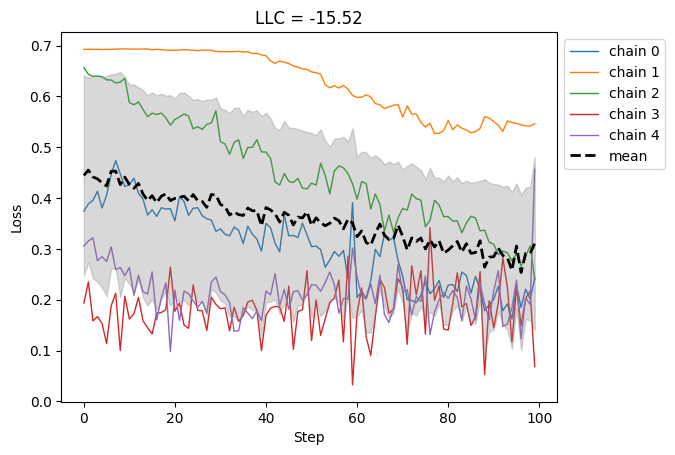

<Figure size 1200x900 with 0 Axes>

In [5]:
from palindrome import check_palindrome
from tracr.haiku_to_pytorch import haiku_to_pytorch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

bos = "BOS"
init_model = check_palindrome()
base_model = haiku_to_pytorch(init_model)

init_vocab = ['a', 'b', 'c', 'd', 'e']
init_label = lambda data: int(list(data) == list(data)[::-1])
init_seq_len = 5

token_to_idx = init_model.input_encoder.encoding_map
vocab_list = list(token_to_idx.keys())
vocab_size = init_model.input_encoder.vocab_size
d_model = base_model.layers[0].attn.d_model
max_pos = init_model.params['pos_embed']['embeddings'].shape[0]

print(f"Vocab size: {vocab_size}, d_model: {d_model}")

class TracrWithEmbeddings(nn.Module):
    def __init__(self, base_model, vocab_size, d_model, max_pos, token_to_idx, haiku_model):
        super().__init__()
        self.base_model = base_model
        self.token_to_idx = token_to_idx
        self.vocab_size = vocab_size
        
        self.token_embed = nn.Embedding(vocab_size, d_model, dtype=torch.float64)
        self.pos_embed = nn.Embedding(max_pos, d_model, dtype=torch.float64)
        
        with torch.no_grad():
            token_emb_weights = torch.tensor(
                np.array(haiku_model.params['token_embed']['embeddings']),
                dtype=torch.float64
            )
            self.token_embed.weight.copy_(token_emb_weights)
            
            pos_emb_weights = torch.tensor(
                np.array(haiku_model.params['pos_embed']['embeddings']),
                dtype=torch.float64
            )
            self.pos_embed.weight.copy_(pos_emb_weights)
    
    def forward(self, x):
        batch_indices = []
        for seq in x:
            indices = [self.token_to_idx[token] for token in seq]
            batch_indices.append(indices)
        
        x_indices = torch.tensor(batch_indices, dtype=torch.long, device=self.token_embed.weight.device)
        tok_emb = self.token_embed(x_indices)
        pos_emb = self.pos_embed(torch.arange(x_indices.shape[1], device=x_indices.device))
        x = tok_emb + pos_emb
        
        for layer in self.base_model.layers:
            x = layer(x)
        
        return x

base_transformer = TracrWithEmbeddings(base_model, vocab_size, d_model, max_pos, token_to_idx, init_model)
base_transformer = base_transformer.to(DEVICE)

# Find output dimension
print("\n=== Finding TRACR output dimension ===")
validation_sequences = [
    ["BOS", "a", "b", "b", "a", "a"],  # False
    ["BOS", "a", "a", "a", "a", "a"],  # True
    ["BOS", "a", "b", "c", "b", "a"],  # True
]

base_transformer.eval()
with torch.no_grad():
    hidden = base_transformer(validation_sequences)
    perfect_dims = []
    
    for dim in range(d_model):
        all_correct = True
        for i, seq in enumerate(validation_sequences):
            seq_no_bos = seq[1:]
            is_palindrome = (seq_no_bos == seq_no_bos[::-1])
            values = [hidden[i, pos, dim].item() for pos in range(1, len(seq))]
            all_high = all(v > 0.5 for v in values)
            if all_high != is_palindrome:
                all_correct = False
                break
        if all_correct:
            perfect_dims.append(dim)
    
    PALINDROME_DIM = perfect_dims[0]
    print(f"✓ Output dimension: {PALINDROME_DIM}")

# ===== CORRECT CLASSIFIER =====
class TracrFullModelClassifier(nn.Module):
    """
    This is the KEY insight:
    - TRACR computes per-position palindrome checks across ALL layers
    - The answer is: min(all_positions[palindrome_dim]) > 0.5
    - We add a learnable aggregator to do this properly
    """
    def __init__(self, transformer, d_model, palindrome_dim):
        super().__init__()
        self.transformer = transformer  # Full TRACR model
        self.palindrome_dim = palindrome_dim
        
        # Learnable aggregator that combines information from all positions
        # Input: (seq_len-1) position values from palindrome_dim
        # Output: 2 logits (False/True)
        # We'll use a simple architecture that can learn "min" or "all must be high"
        self.aggregator = nn.Sequential(
            nn.Linear(d_model, 32, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(32, 2, dtype=torch.float64)
        )
        
        # Initialize to roughly implement "check if all positions are high"
        # This gives it a good starting point
        with torch.no_grad():
            # First layer: focus on palindrome dimension
            self.aggregator[0].weight.zero_()
            self.aggregator[0].weight[:, palindrome_dim] = 1.0
            self.aggregator[0].bias.fill_(-0.5)  # Bias to detect high values
            
            # Output layer
            self.aggregator[2].weight.normal_(0, 0.01)
            self.aggregator[2].bias.zero_()
    
    def forward(self, x):
        # Run FULL TRACR model
        hidden = self.transformer(x)  # (batch, seq_len, d_model)
        
        # Aggregate across all positions (except BOS)
        # We use MEAN pooling of the non-BOS positions
        # This lets the network learn to detect "all positions are True"
        non_bos_hidden = hidden[:, 1:, :]  # (batch, seq_len-1, d_model)
        
        # Mean pool across positions
        pooled = non_bos_hidden.mean(dim=1)  # (batch, d_model)
        
        # Decode to logits
        logits = self.aggregator(pooled)  # (batch, 2)
        
        return logits

model = TracrFullModelClassifier(base_transformer, d_model, PALINDROME_DIM)

# Make ALL parameters trainable
for param in model.parameters():
    param.requires_grad = True

model = model.to(DEVICE)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTrainable parameters: {trainable_params:,}")

# Dataset
class GeneralDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, seq_len, num_samples):
        self.vocab = vocab
        self.seq_len = seq_len
        self.num_samples = num_samples
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        seq = [np.random.choice(self.vocab) for _ in range(self.seq_len)]
        label = init_label(seq)
        full_seq = ["BOS"] + seq
        return full_seq, label

def custom_collate(batch):
    sequences, labels = zip(*batch)
    return list(sequences), torch.tensor(labels, dtype=torch.long)

vocab = init_vocab 
data = GeneralDataset(vocab=vocab, seq_len=init_seq_len, num_samples=10000) 
loader = torch.utils.data.DataLoader(data, batch_size=256, shuffle=True, collate_fn=custom_collate)

def evaluate(model, batch):
    sequences, labels = batch  
    labels = labels.to(DEVICE)
    logits = model(sequences)
    loss = F.cross_entropy(logits, labels)
    return loss

# Test accuracy
print("\n=== Testing Accuracy ===")
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch in loader:
        sequences, labels = batch
        logits = model(sequences)
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels.to(DEVICE)).sum().item()
        total += len(labels)
    
    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f} ({correct}/{total})")

if accuracy < 0.9:
    print("⚠️ Accuracy is low - aggregator initialization may need tuning")
    print("But this is OK! The aggregator will be learned during LLC sampling")

model.train()

print("\n=== Estimating LLC ===")

learning_coeff_stats = estimate_learning_coeff_with_summary(
    model,
    loader=loader,
    evaluate=evaluate,
    sampling_method=SGLD,
    optimizer_kwargs=dict(
        lr=1e-7,
        localization=0.01,
        nbeta=default_nbeta(loader)
    ),
    num_chains=5,
    num_draws=100,
    num_burnin_steps=100,
    num_steps_bw_draws=1,
    device=DEVICE,
    online=True,
)

print("\n=== LLC Results ===")
print(f"LLC means per chain: {learning_coeff_stats['llc/means']}")
print(f"Average LLC: {np.mean(learning_coeff_stats['llc/means']):.2f}")
print(f"Std across chains: {np.std(learning_coeff_stats['llc/means']):.2f}")

plot_trace(
    learning_coeff_stats["loss/trace"],
    "Loss",
    x_axis="Step",
    title=f"LLC = {np.mean(learning_coeff_stats['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)

Using device: cpu
Compiling TRACR model...
Vocab size: 7, d_model: 48, max_pos: 6

=== Analyzing compiled model structure ===
Output shape: torch.Size([3, 5, 48])
Residual stream dimensions: 48
Dimensions that vary between palindrome/non-palindrome: [0, 1, 2, 3, 10, 39, 40, 42, 43, 44, 46]

Trainable parameters: 28,988

=== Creating dataset ===

=== Testing initial accuracy ===
Initial accuracy: 0.9231 (9231/10000)

=== Estimating LLC ===


Chain 4: 100%|██████████| 200/200 [00:05<00:00, 39.30it/s]



=== LLC Results ===
LLC means per chain: [ 0.00288336  0.00518024  0.0023138  -0.00370558 -0.00807526 -0.0119531
 -0.00837178 -0.01793167 -0.01998297 -0.01652336 -0.01177155 -0.01919838
 -0.01881396 -0.0157025  -0.01670711 -0.01838792 -0.01446662 -0.01325301
 -0.00875497 -0.00901572 -0.00981159 -0.01103193 -0.0067557  -0.00935534
 -0.00375627 -0.00903148 -0.00861561 -0.01623055 -0.01853404 -0.02162674
 -0.02233269 -0.02451902 -0.01663377 -0.01493358 -0.00679722 -0.00198206
  0.00062121  0.00137026 -0.00237447  0.00041863 -0.01031708 -0.00721132
  0.00056361  0.00031123 -0.00293504 -0.00475031 -0.00135656 -0.00118069
  0.00553863 -0.00119382  0.00216941  0.00226818  0.00871308  0.00627747
  0.00157722 -0.00295173 -0.00345402 -0.00039423 -0.00307577  0.00269614
  0.00036436  0.00200792  0.00537782  0.01163671  0.01035333  0.00105642
  0.001266    0.00634228  0.004546    0.01292542  0.01911105  0.02075873
  0.0238675   0.02439062  0.03641221  0.03774015  0.03952572  0.04146002
  0.038301

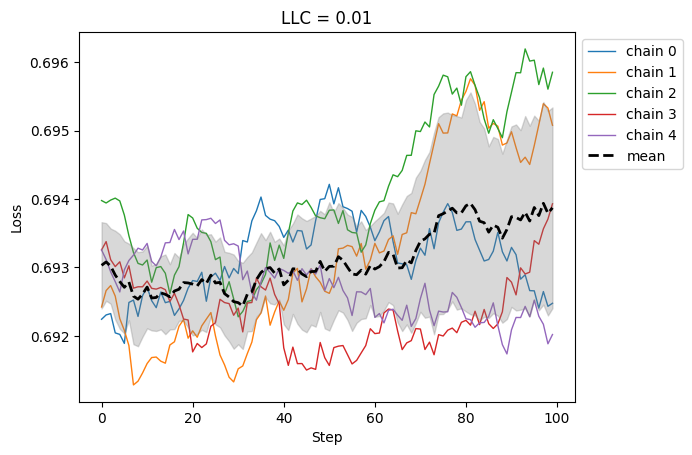

<Figure size 1200x900 with 0 Axes>

In [8]:
from tracr.rasp import rasp
from tracr.compiler import compiling
from tracr.haiku_to_pytorch import haiku_to_pytorch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ============================================================================
# IMPROVED PALINDROME RASP PROGRAM - Returns numerical score
# ============================================================================

def is_palindrome_numerical(tokens):
    """
    Returns a numerical value per position:
    - 1.0 if that position matches its reverse position
    - 0.0 if it doesn't match
    
    For a true palindrome, all positions will be 1.0
    """
    all_true_selector = rasp.Select(tokens, tokens, rasp.Comparison.TRUE)
    length = rasp.SelectorWidth(all_true_selector)

    opp_idx = (length - rasp.indices).named("opp_idx")
    opp_idx = (opp_idx - 1).named("opp_idx-1")
    reverse_selector = rasp.Select(rasp.indices, opp_idx, rasp.Comparison.EQ)
    reverse = rasp.Aggregate(reverse_selector, tokens)

    # Convert boolean check to numerical (1.0 or 0.0)
    check = rasp.SequenceMap(lambda x, y: x == y, tokens, reverse)
    check_numerical = rasp.Map(lambda b: 1.0 if b else 0.0, check)
    check_numerical = rasp.numerical(check_numerical)
    
    return check_numerical


def compile_palindrome_model():
    """Compile the palindrome checker to a transformer model."""
    bos = "BOS"
    
    vocab = {'a', 'b', 'c', 'd', 'e'}
    max_seq_len = 5
    
    model = compiling.compile_rasp_to_model(
        program=is_palindrome_numerical(rasp.tokens),
        vocab=vocab,
        max_seq_len=max_seq_len,
        compiler_bos=bos,
    )
    
    return model, vocab, max_seq_len, bos


# ============================================================================
# MODEL WRAPPER FOR PYTORCH
# ============================================================================

class TracrWithEmbeddings(nn.Module):
    def __init__(self, base_model, vocab_size, d_model, max_pos, token_to_idx, haiku_model):
        super().__init__()
        self.base_model = base_model
        self.token_to_idx = token_to_idx
        self.vocab_size = vocab_size
        
        self.token_embed = nn.Embedding(vocab_size, d_model, dtype=torch.float64)
        self.pos_embed = nn.Embedding(max_pos, d_model, dtype=torch.float64)
        
        # Copy weights from Haiku model
        with torch.no_grad():
            token_emb_weights = torch.tensor(
                np.array(haiku_model.params['token_embed']['embeddings']),
                dtype=torch.float64
            )
            self.token_embed.weight.copy_(token_emb_weights)
            
            pos_emb_weights = torch.tensor(
                np.array(haiku_model.params['pos_embed']['embeddings']),
                dtype=torch.float64
            )
            self.pos_embed.weight.copy_(pos_emb_weights)
    
    def forward(self, x):
        """
        x: List of sequences, where each sequence is a list of tokens
        """
        batch_indices = []
        for seq in x:
            indices = [self.token_to_idx[token] for token in seq]
            batch_indices.append(indices)
        
        x_indices = torch.tensor(batch_indices, dtype=torch.long, device=self.token_embed.weight.device)
        tok_emb = self.token_embed(x_indices)
        pos_emb = self.pos_embed(torch.arange(x_indices.shape[1], device=x_indices.device))
        x = tok_emb + pos_emb
        
        for layer in self.base_model.layers:
            x = layer(x)
        
        return x


class PalindromeClassifier(nn.Module):
    """
    Classifier that reads from the TRACR model's output and produces class logits.
    The TRACR model outputs per-position boolean checks (True/False at each position).
    We need to aggregate these into a single classification.
    """
    def __init__(self, transformer, d_model, output_dim_indices):
        super().__init__()
        self.transformer = transformer
        self.d_model = d_model
        self.output_dim_indices = output_dim_indices  # Which dims encode True/False
        
        # Learnable aggregator: takes per-position checks and outputs classification
        # Input: concatenated features from all non-BOS positions
        # We'll use mean pooling to aggregate the per-position outputs
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 32, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(32, 2, dtype=torch.float64)
        )
        
        # Initialize
        with torch.no_grad():
            for layer in self.classifier:
                if isinstance(layer, nn.Linear):
                    layer.weight.normal_(0, 0.01)
                    layer.bias.zero_()
    
    def forward(self, x):
        """
        Returns logits for [False, True] classes
        """
        hidden = self.transformer(x)  # (batch, seq_len, d_model)
        
        # Average pool over non-BOS positions (positions 1 onwards)
        pooled = hidden[:, 1:, :].mean(dim=1)  # (batch, d_model)
        
        logits = self.classifier(pooled)  # (batch, 2)
        return logits


# ============================================================================
# DATASET
# ============================================================================

class PalindromeDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, seq_len, num_samples, bos="BOS"):
        self.vocab = list(vocab)
        self.seq_len = seq_len
        self.num_samples = num_samples
        self.bos = bos
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Generate random sequence
        seq = [np.random.choice(self.vocab) for _ in range(self.seq_len)]
        
        # Check if palindrome
        is_palindrome = (seq == seq[::-1])
        label = 1 if is_palindrome else 0
        
        # Add BOS token
        full_seq = [self.bos] + seq
        
        return full_seq, label


def custom_collate(batch):
    sequences, labels = zip(*batch)
    return list(sequences), torch.tensor(labels, dtype=torch.long)


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Compile model
    print("Compiling TRACR model...")
    init_model, vocab, max_seq_len, bos = compile_palindrome_model()
    base_model = haiku_to_pytorch(init_model)
    
    # Extract model info
    token_to_idx = init_model.input_encoder.encoding_map
    vocab_size = init_model.input_encoder.vocab_size
    d_model = base_model.layers[0].attn.d_model
    max_pos = init_model.params['pos_embed']['embeddings'].shape[0]
    
    print(f"Vocab size: {vocab_size}, d_model: {d_model}, max_pos: {max_pos}")
    
    # Create transformer with embeddings
    transformer = TracrWithEmbeddings(
        base_model, vocab_size, d_model, max_pos, token_to_idx, init_model
    ).to(DEVICE)
    
    # Find output dimensions by inspecting model structure
    print("\n=== Analyzing compiled model structure ===")
    
    # The output of your RASP program is categorical (True/False) per position
    # We need to find which dimensions encode this
    test_sequences = [
        ["BOS", "a", "b", "b", "a"],  # Palindrome - all positions should be True
        ["BOS", "a", "b", "c", "d"],  # Not palindrome - positions should be False
        ["BOS", "c", "d", "d", "c"],  # Palindrome - all positions should be True
    ]
    
    transformer.eval()
    with torch.no_grad():
        hidden = transformer(test_sequences)
        print(f"Output shape: {hidden.shape}")
        print(f"Residual stream dimensions: {d_model}")
        
        # Check which dimensions vary between palindrome and non-palindrome
        pal_out = hidden[0, 1:, :]  # First sequence (palindrome), non-BOS positions
        non_pal_out = hidden[1, 1:, :]  # Second sequence (not palindrome)
        
        # Find dimensions that distinguish palindromes
        diff = (pal_out.mean(0) - non_pal_out.mean(0)).abs()
        important_dims = torch.where(diff > 0.1)[0]
        print(f"Dimensions that vary between palindrome/non-palindrome: {important_dims.tolist()}")
        
    output_dims = important_dims.tolist() if len(important_dims) > 0 else list(range(d_model))
    
    # Create full model with classifier
    model = PalindromeClassifier(transformer, d_model, output_dims).to(DEVICE)
    
    # Make all parameters trainable (including transformer)
    for param in model.parameters():
        param.requires_grad = True
    
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTrainable parameters: {trainable_params:,}")
    
    # Create dataset
    print("\n=== Creating dataset ===")
    dataset = PalindromeDataset(vocab, max_seq_len, num_samples=10000, bos=bos)
    loader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=256, 
        shuffle=True, 
        collate_fn=custom_collate
    )
    
    # Test accuracy before training
    print("\n=== Testing initial accuracy ===")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            sequences, labels = batch
            labels = labels.to(DEVICE)
            logits = model(sequences)
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += len(labels)
    
    initial_accuracy = correct / total
    print(f"Initial accuracy: {initial_accuracy:.4f} ({correct}/{total})")
    
    # Define evaluation function for LLC
    def evaluate(model, data):
        sequences, labels = data
        labels = labels.to(DEVICE)
        logits = model(sequences)
        loss = F.cross_entropy(logits, labels)
        return loss
    
    # Estimate LLC
    print("\n=== Estimating LLC ===")
    model.train()
    
    learning_coeff_stats = estimate_learning_coeff_with_summary(
        model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=SGLD,
        optimizer_kwargs=dict(
            lr=1e-7,
            localization=0.01,
            nbeta=default_nbeta(loader)
        ),
        num_chains=5,
        num_draws=100,
        num_burnin_steps=100,
        num_steps_bw_draws=1,
        device=DEVICE,
        online=True,
    )
    
    print("\n=== LLC Results ===")
    print(f"LLC means per chain: {learning_coeff_stats['llc/means']}")
    print(f"Average LLC: {np.mean(learning_coeff_stats['llc/means']):.2f}")
    print(f"Std across chains: {np.std(learning_coeff_stats['llc/means']):.2f}")
    
    # Plot results
    plot_trace(
        learning_coeff_stats["loss/trace"],
        "Loss",
        x_axis="Step",
        title=f"LLC = {np.mean(learning_coeff_stats['llc/means']):.2f}",
        plot_mean=False,
        plot_std=False,
        fig_size=(12, 9),
        true_lc=None,
    )

In [4]:
from tracr.rasp import rasp
from tracr.compiler import compiling
from tracr.haiku_to_pytorch import haiku_to_pytorch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ============================================================================
# IMPROVED PALINDROME RASP PROGRAM - Returns numerical score
# ============================================================================

def is_palindrome_numerical(tokens):
    """
    Returns a numerical value per position:
    - 1.0 if that position matches its reverse position
    - 0.0 if it doesn't match
    
    For a true palindrome, all positions will be 1.0
    """
    all_true_selector = rasp.Select(tokens, tokens, rasp.Comparison.TRUE)
    length = rasp.SelectorWidth(all_true_selector)

    opp_idx = (length - rasp.indices).named("opp_idx")
    opp_idx = (opp_idx - 1).named("opp_idx-1")
    reverse_selector = rasp.Select(rasp.indices, opp_idx, rasp.Comparison.EQ)
    reverse = rasp.Aggregate(reverse_selector, tokens)

    # Convert boolean check to numerical (1.0 or 0.0)
    check = rasp.SequenceMap(lambda x, y: x == y, tokens, reverse)
    check_numerical = rasp.Map(lambda b: 1.0 if b else 0.0, check)
    check_numerical = rasp.numerical(check_numerical)
    
    return check_numerical


def compile_palindrome_model():
    """Compile the palindrome checker to a transformer model."""
    bos = "BOS"
    
    vocab = {'a', 'b', 'c', 'd', 'e'}
    max_seq_len = 5
    
    model = compiling.compile_rasp_to_model(
        program=is_palindrome_numerical(rasp.tokens),
        vocab=vocab,
        max_seq_len=max_seq_len,
        compiler_bos=bos,
    )
    
    return model, vocab, max_seq_len, bos


# ============================================================================
# MODEL WRAPPER FOR PYTORCH
# ============================================================================

class TracrWithEmbeddings(nn.Module):
    def __init__(self, base_model, vocab_size, d_model, max_pos, token_to_idx, haiku_model):
        super().__init__()
        self.base_model = base_model
        self.token_to_idx = token_to_idx
        self.vocab_size = vocab_size
        
        self.token_embed = nn.Embedding(vocab_size, d_model, dtype=torch.float64)
        self.pos_embed = nn.Embedding(max_pos, d_model, dtype=torch.float64)
        
        # Copy weights from Haiku model
        with torch.no_grad():
            token_emb_weights = torch.tensor(
                np.array(haiku_model.params['token_embed']['embeddings']),
                dtype=torch.float64
            )
            self.token_embed.weight.copy_(token_emb_weights)
            
            pos_emb_weights = torch.tensor(
                np.array(haiku_model.params['pos_embed']['embeddings']),
                dtype=torch.float64
            )
            self.pos_embed.weight.copy_(pos_emb_weights)
    
    def forward(self, x):
        """
        x: List of sequences, where each sequence is a list of tokens
        """
        batch_indices = []
        for seq in x:
            indices = [self.token_to_idx[token] for token in seq]
            batch_indices.append(indices)
        
        x_indices = torch.tensor(batch_indices, dtype=torch.long, device=self.token_embed.weight.device)
        tok_emb = self.token_embed(x_indices)
        pos_emb = self.pos_embed(torch.arange(x_indices.shape[1], device=x_indices.device))
        x = tok_emb + pos_emb
        
        for layer in self.base_model.layers:
            x = layer(x)
        
        return x


class PalindromeClassifier(nn.Module):
    """
    Classifier that reads from the TRACR model's output and produces class logits.
    The TRACR model outputs per-position boolean checks (True/False at each position).
    We need to aggregate these into a single classification.
    """
    def __init__(self, transformer, d_model, output_dim_indices):
        super().__init__()
        self.transformer = transformer
        self.d_model = d_model
        self.output_dim_indices = output_dim_indices  # Which dims encode True/False
        
        # Learnable aggregator: takes per-position checks and outputs classification
        # Input: concatenated features from all non-BOS positions
        # We'll use mean pooling to aggregate the per-position outputs
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 32, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(32, 2, dtype=torch.float64)
        )
        
        # Initialize
        with torch.no_grad():
            for layer in self.classifier:
                if isinstance(layer, nn.Linear):
                    layer.weight.normal_(0, 0.01)
                    layer.bias.zero_()
    
    def forward(self, x):
        """
        Returns logits for [False, True] classes
        """
        hidden = self.transformer(x)  # (batch, seq_len, d_model)
        
        # Average pool over non-BOS positions (positions 1 onwards)
        pooled = hidden[:, 1:, :].mean(dim=1)  # (batch, d_model)
        
        logits = self.classifier(pooled)  # (batch, 2)
        return logits


# ============================================================================
# DATASET
# ============================================================================

class PalindromeDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, seq_len, num_samples, bos="BOS"):
        self.vocab = list(vocab)
        self.seq_len = seq_len
        self.num_samples = num_samples
        self.bos = bos
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Generate random sequence
        seq = [np.random.choice(self.vocab) for _ in range(self.seq_len)]
        
        # Check if palindrome
        is_palindrome = (seq == seq[::-1])
        label = 1 if is_palindrome else 0
        
        # Add BOS token
        full_seq = [self.bos] + seq
        
        return full_seq, label


def custom_collate(batch):
    sequences, labels = zip(*batch)
    return list(sequences), torch.tensor(labels, dtype=torch.long)


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Compile model
    print("Compiling TRACR model...")
    init_model, vocab, max_seq_len, bos = compile_palindrome_model()
    base_model = haiku_to_pytorch(init_model)
    
    # Extract model info
    token_to_idx = init_model.input_encoder.encoding_map
    vocab_size = init_model.input_encoder.vocab_size
    d_model = base_model.layers[0].attn.d_model
    max_pos = init_model.params['pos_embed']['embeddings'].shape[0]
    
    print(f"Vocab size: {vocab_size}, d_model: {d_model}, max_pos: {max_pos}")
    
    # Create transformer with embeddings
    transformer = TracrWithEmbeddings(
        base_model, vocab_size, d_model, max_pos, token_to_idx, init_model
    ).to(DEVICE)

# After creating transformer, test it directly
print("\n=== Testing TRACR directly ===")
test_seqs = [
    ["BOS", "a", "b", "b", "a"],  # Palindrome
    ["BOS", "a", "b", "c", "d"],  # Not palindrome
]

transformer.eval()
with torch.no_grad():
    out = transformer(test_seqs)
    print("Output shape:", out.shape)
    print("\nPalindrome:", out[0, 1:, :].mean(dim=0))
    print("Not palindrome:", out[1, 1:, :].mean(dim=0))
    
    # Find which dimensions differ
    diff = (out[0, 1:, :] - out[1, 1:, :]).abs().mean(dim=0)
    important = torch.where(diff > 0.1)[0]
    print(f"\nImportant dimensions: {important.tolist()}")
    print(f"Palindrome values: {out[0, 1:, important].mean(dim=0)}")
    print(f"Not-palindrome values: {out[1, 1:, important].mean(dim=0)}")

Using device: cpu
Compiling TRACR model...
Vocab size: 7, d_model: 48, max_pos: 6

=== Testing TRACR directly ===
Output shape: torch.Size([2, 5, 48])

Palindrome: tensor([5.0000e-01, 5.0000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.5000e-01,
        2.5000e-01, 2.5000e-01, 2.5000e-01, 0.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.5000e-01,
        2.5000e-01, 2.5000e-01, 2.5000e-01, 5.5511e-17, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.5000e-01, 2.5000e-01, 2.5000e-01,
        2.5000e-01, 5.5511e-17, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 2.2204e-16, 2.0000e-01, 5.8076e-13, 1.0000e+00, 0.0000e+00,
        5.0000e-01, 5.0000e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
       dtype=torch.float64)
Not palindrome: tensor([2.5000e-01, 2.5000e-01, 2.5000e-01, 2.5000e-01, 0.0000e+00, 2.5000e-01,
        2.5000e-01, 2.5000e-01, 2.5000e-01, 0.0000e+00, 2.9043e-13, 1.0

In [5]:
print("\n=== Detailed per-position analysis ===")

test_sequences = [
    ["BOS", "a", "b", "b", "a"],  # Palindrome
    ["BOS", "a", "b", "c", "d"],  # Not palindrome
]

transformer.eval()
with torch.no_grad():
    hidden = transformer(test_sequences)
    
    for seq_idx, seq in enumerate(test_sequences):
        print(f"\n{'='*50}")
        print(f"Sequence {seq_idx}: {seq[1:]}")
        print(f"Expected: {'PALINDROME' if seq[1:] == seq[1:][::-1] else 'NOT PALINDROME'}")
        
        # Look at each position individually
        for pos in range(1, len(seq)):
            print(f"\n  Position {pos} ('{seq[pos]}'):")
            pos_values = hidden[seq_idx, pos, :]
            
            # Find dimensions with values close to 0 or 1
            near_zero = torch.where(pos_values.abs() < 0.1)[0]
            near_one = torch.where((pos_values - 1.0).abs() < 0.1)[0]
            
            if len(near_one) > 0:
                print(f"    Dimensions near 1.0: {near_one.tolist()[:5]}...")  # Show first 5
                print(f"    Values: {pos_values[near_one[:5]].tolist()}")
            
            if len(near_zero) > 10:  # Most will be zero
                print(f"    {len(near_zero)} dimensions near 0.0")
        
        # Now look for dimensions that are consistently 1.0 across ALL positions for palindrome
        all_positions = hidden[seq_idx, 1:, :]  # (seq_len-1, d_model)
        
        # Which dimensions are close to 1.0 in ALL positions?
        all_near_one = ((all_positions - 1.0).abs() < 0.1).all(dim=0)  # (d_model,)
        consistent_dims = torch.where(all_near_one)[0]
        
        print(f"\n  Dimensions that are ~1.0 at ALL positions: {consistent_dims.tolist()}")
        if len(consistent_dims) > 0:
            print(f"  Values: {all_positions[:, consistent_dims].mean(dim=0).tolist()}")


=== Detailed per-position analysis ===

Sequence 0: ['a', 'b', 'b', 'a']
Expected: PALINDROME

  Position 1 ('a'):
    Dimensions near 1.0: [0, 5, 10, 11, 20]...
    Values: [0.9999994611109821, 1.0, 0.9999994611109821, 1.0, 0.9999999999999998]
    38 dimensions near 0.0

  Position 2 ('b'):
    Dimensions near 1.0: [1, 6, 10, 11, 19]...
    Values: [0.9999994611109821, 1.0, 0.9999994611109821, 1.0, 0.9999999999999998]
    38 dimensions near 0.0

  Position 3 ('b'):
    Dimensions near 1.0: [1, 7, 10, 11, 18]...
    Values: [0.9999994611109819, 1.0, 0.9999994611109819, 1.0, 0.9999999999999998]
    38 dimensions near 0.0

  Position 4 ('a'):
    Dimensions near 1.0: [0, 8, 10, 11, 17]...
    Values: [0.9999994611109821, 1.0, 0.9999994611109821, 1.0, 0.9999999999999998]
    38 dimensions near 0.0

  Dimensions that are ~1.0 at ALL positions: [10, 11, 36, 40]
  Values: [0.9999994611109821, 1.0, 0.9999999999999998, 0.9999994611109821]

Sequence 1: ['a', 'b', 'c', 'd']
Expected: NOT PALIND

In [6]:
print("\n=== Understanding TRACR's encoding ===")

# Test on a longer, more complex case
test_cases = [
    ["BOS", "a", "b", "b", "a"],      # Full palindrome
    ["BOS", "a", "b", "c", "d"],      # No matches
    ["BOS", "a", "b", "c", "b"],      # Partial: middle doesn't match
    ["BOS", "c", "c", "c", "c"],      # All same (palindrome)
]

transformer.eval()
with torch.no_grad():
    hidden = transformer(test_cases)
    
    for seq_idx, seq in enumerate(test_cases):
        print(f"\n{'='*60}")
        print(f"Sequence: {seq[1:]}")
        
        # Manual check: which positions should match?
        tokens_only = seq[1:]
        n = len(tokens_only)
        expected_matches = []
        for i in range(n):
            mirror_i = n - 1 - i
            matches = (tokens_only[i] == tokens_only[mirror_i])
            expected_matches.append(matches)
        
        print(f"Expected matches per position: {expected_matches}")
        
        # What does dimension 39 say?
        dim_39_values = hidden[seq_idx, 1:, 39].tolist()
        print(f"Dimension 39 values:          {[f'{v:.2f}' for v in dim_39_values]}")
        
        # Are they consistent?
        dim_39_binary = [v > 0.5 for v in dim_39_values]
        print(f"Dimension 39 as binary:       {dim_39_binary}")
        print(f"Match expected? {dim_39_binary == expected_matches}")
        
        is_palindrome = all(expected_matches)
        print(f"\nIs palindrome? {is_palindrome}")
        print(f"Min(dim 39) = {min(dim_39_values):.4f} → predicts palindrome: {min(dim_39_values) > 0.5}")


=== Understanding TRACR's encoding ===

Sequence: ['a', 'b', 'b', 'a']
Expected matches per position: [True, True, True, True]
Dimension 39 values:          ['0.00', '0.00', '0.00', '0.00']
Dimension 39 as binary:       [False, False, False, False]
Match expected? False

Is palindrome? True
Min(dim 39) = 0.0000 → predicts palindrome: False

Sequence: ['a', 'b', 'c', 'd']
Expected matches per position: [False, False, False, False]
Dimension 39 values:          ['1.00', '1.00', '1.00', '1.00']
Dimension 39 as binary:       [True, True, True, True]
Match expected? False

Is palindrome? False
Min(dim 39) = 1.0000 → predicts palindrome: True

Sequence: ['a', 'b', 'c', 'b']
Expected matches per position: [False, False, False, False]
Dimension 39 values:          ['1.00', '1.00', '1.00', '1.00']
Dimension 39 as binary:       [True, True, True, True]
Match expected? False

Is palindrome? False
Min(dim 39) = 1.0000 → predicts palindrome: True

Sequence: ['c', 'c', 'c', 'c']
Expected matches pe

Using device: cpu
Compiling TRACR model...
Vocab size: 7, d_model: 48, max_pos: 6

Trainable parameters: 5,282

=== Creating dataset ===

=== Training classifier ===
Epoch 1: Loss=0.5927, Acc=0.9555
Reached 0.9555 accuracy, stopping training.

=== Testing final accuracy ===
Final accuracy: 0.9596 (9596/10000)

=== Estimating LLC ===


/Users/meerigupta/Downloads/llc-interpretability/venv/lib/python3.12/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/meerigupta/Downloads/llc-interpretability/venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/meerigupta/Downloads/llc-interpretability/venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:244: UserWarning: You are taking more sample batches than there are dataloader batches available, this removes some randomness from sampling but is probably fine. (All sample batches beyond the number dataloader batches are cycled from the start, f.e. 9 samples from [A, B, C] would be [B, A, C, B, A, C, B, A, C].)
  warnings.warn(
/Users/meerigupta/Down


=== LLC Results ===
LLC means per chain: [ 7.19967857e-02 -5.22244167e+00 -3.60853577e+00 -6.29022217e+00
 -4.30011272e+00 -3.50012398e+00 -2.48557162e+00  6.62936544e+00
 -3.23900795e+00  6.70948696e+00 -6.22098827e+00 -3.23549318e+00
 -3.01298571e+00 -5.32558727e+00 -4.61846161e+00 -2.45912480e+00
 -7.61082745e+00 -4.99519527e-01  4.07599270e-01 -1.45945358e+00
 -3.28506857e-01  1.03696756e+01  1.10218735e+01  1.95999885e+00
  9.32187080e+00  9.56125259e+00  5.38679218e+00  6.34844112e+00
  1.09546204e+01  5.22571182e+00  1.55666094e+01  1.18622656e+01
  2.35574837e+01  1.90200062e+01  7.14961910e+00  8.13397980e+00
  7.57206821e+00  4.80242014e+00  9.98929405e+00 -3.53470373e+00
  8.73769569e+00  1.71827946e+01  1.00256624e+01  4.37009954e+00
  1.99471626e+01  5.04276800e+00  1.14611282e+01  4.58283710e+00
 -5.41799247e-01  1.06145813e+02  3.17032070e+01  2.86947727e+01
  4.91290512e+01  1.79604836e+01  2.05974159e+01  5.52008438e+01
  7.59973068e+01  1.24001816e+02  9.63897171e+01

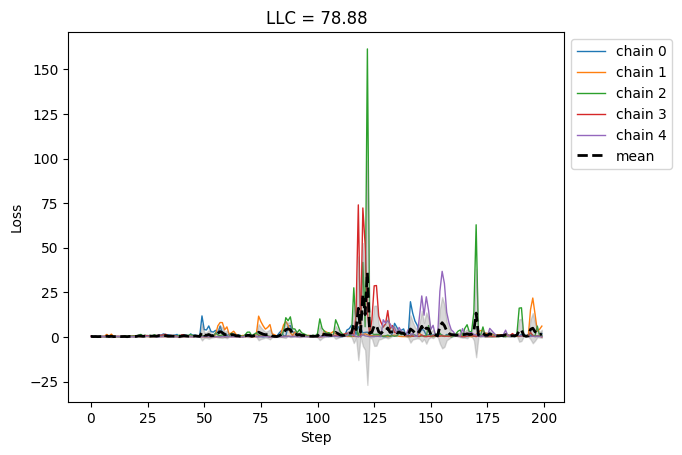

<Figure size 1200x900 with 0 Axes>

In [7]:
from tracr.rasp import rasp
from tracr.compiler import compiling
from tracr.haiku_to_pytorch import haiku_to_pytorch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ============================================================================
# IMPROVED PALINDROME RASP PROGRAM - Returns numerical score
# ============================================================================

def is_palindrome_numerical(tokens):
    """
    Returns a numerical value per position:
    - 1.0 if that position matches its reverse position
    - 0.0 if it doesn't match
    
    For a true palindrome, all positions will be 1.0
    """
    all_true_selector = rasp.Select(tokens, tokens, rasp.Comparison.TRUE)
    length = rasp.SelectorWidth(all_true_selector)

    opp_idx = (length - rasp.indices).named("opp_idx")
    opp_idx = (opp_idx - 1).named("opp_idx-1")
    reverse_selector = rasp.Select(rasp.indices, opp_idx, rasp.Comparison.EQ)
    reverse = rasp.Aggregate(reverse_selector, tokens)

    # Convert boolean check to numerical (1.0 or 0.0)
    check = rasp.SequenceMap(lambda x, y: x == y, tokens, reverse)
    check_numerical = rasp.Map(lambda b: 1.0 if b else 0.0, check)
    check_numerical = rasp.numerical(check_numerical)
    
    return check_numerical


def compile_palindrome_model():
    """Compile the palindrome checker to a transformer model."""
    bos = "BOS"
    
    vocab = {'a', 'b', 'c', 'd', 'e'}
    max_seq_len = 5
    
    model = compiling.compile_rasp_to_model(
        program=is_palindrome_numerical(rasp.tokens),
        vocab=vocab,
        max_seq_len=max_seq_len,
        compiler_bos=bos,
    )
    
    return model, vocab, max_seq_len, bos


# ============================================================================
# MODEL WRAPPER FOR PYTORCH
# ============================================================================

class TracrWithEmbeddings(nn.Module):
    def __init__(self, base_model, vocab_size, d_model, max_pos, token_to_idx, haiku_model):
        super().__init__()
        self.base_model = base_model
        self.token_to_idx = token_to_idx
        self.vocab_size = vocab_size
        
        self.token_embed = nn.Embedding(vocab_size, d_model, dtype=torch.float64)
        self.pos_embed = nn.Embedding(max_pos, d_model, dtype=torch.float64)
        
        # Copy weights from Haiku model
        with torch.no_grad():
            token_emb_weights = torch.tensor(
                np.array(haiku_model.params['token_embed']['embeddings']),
                dtype=torch.float64
            )
            self.token_embed.weight.copy_(token_emb_weights)
            
            pos_emb_weights = torch.tensor(
                np.array(haiku_model.params['pos_embed']['embeddings']),
                dtype=torch.float64
            )
            self.pos_embed.weight.copy_(pos_emb_weights)
    
    def forward(self, x):
        """
        x: List of sequences, where each sequence is a list of tokens
        """
        batch_indices = []
        for seq in x:
            indices = [self.token_to_idx[token] for token in seq]
            batch_indices.append(indices)
        
        x_indices = torch.tensor(batch_indices, dtype=torch.long, device=self.token_embed.weight.device)
        tok_emb = self.token_embed(x_indices)
        pos_emb = self.pos_embed(torch.arange(x_indices.shape[1], device=x_indices.device))
        x = tok_emb + pos_emb
        
        for layer in self.base_model.layers:
            x = layer(x)
        
        return x


class PalindromeClassifier(nn.Module):
    """
    Classifier that reads from the TRACR model's output and produces class logits.
    Simple approach: pool the residual stream and learn to classify.
    """
    def __init__(self, transformer, d_model):
        super().__init__()
        self.transformer = transformer
        self.d_model = d_model
        
        # Learnable classifier head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 64, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(64, 32, dtype=torch.float64),
            nn.ReLU(),
            nn.Linear(32, 2, dtype=torch.float64)
        )
        
        # Initialize
        with torch.no_grad():
            for layer in self.classifier:
                if isinstance(layer, nn.Linear):
                    layer.weight.normal_(0, 0.02)
                    layer.bias.zero_()
    
    def forward(self, x):
        """
        Returns logits for [Not-Palindrome, Palindrome] classes
        """
        hidden = self.transformer(x)  # (batch, seq_len, d_model)
        
        # Average pool over all positions
        pooled = hidden.mean(dim=1)  # (batch, d_model)
        
        logits = self.classifier(pooled)  # (batch, 2)
        return logits


# ============================================================================
# DATASET
# ============================================================================

class PalindromeDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, seq_len, num_samples, bos="BOS"):
        self.vocab = list(vocab)
        self.seq_len = seq_len
        self.num_samples = num_samples
        self.bos = bos
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        # Generate random sequence
        seq = [np.random.choice(self.vocab) for _ in range(self.seq_len)]
        
        # Check if palindrome
        is_palindrome = (seq == seq[::-1])
        label = 1 if is_palindrome else 0
        
        # Add BOS token
        full_seq = [self.bos] + seq
        
        return full_seq, label


def custom_collate(batch):
    sequences, labels = zip(*batch)
    return list(sequences), torch.tensor(labels, dtype=torch.long)


# ============================================================================
# EVALUATION FUNCTION (MATCHING DEEPMIND'S SIGNATURE)
# ============================================================================

def evaluate(model, batch):
    """
    Evaluation function matching devinterp's expected signature.
    Must return (loss, optional_dict)
    """
    sequences, labels = batch
    labels = labels.to(DEVICE)
    
    logits = model(sequences)
    loss = F.cross_entropy(logits, labels, reduction='mean')
    
    # Return loss and optional diagnostics dict (like DeepMind does)
    return loss, {"logits": logits}


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Compile model
    print("Compiling TRACR model...")
    init_model, vocab, max_seq_len, bos = compile_palindrome_model()
    base_model = haiku_to_pytorch(init_model)
    
    # Extract model info
    token_to_idx = init_model.input_encoder.encoding_map
    vocab_size = init_model.input_encoder.vocab_size
    d_model = base_model.layers[0].attn.d_model
    max_pos = init_model.params['pos_embed']['embeddings'].shape[0]
    
    print(f"Vocab size: {vocab_size}, d_model: {d_model}, max_pos: {max_pos}")
    
    # Create transformer with embeddings
    transformer = TracrWithEmbeddings(
        base_model, vocab_size, d_model, max_pos, token_to_idx, init_model
    ).to(DEVICE)
    
    # Create full model with classifier
    model = PalindromeClassifier(transformer, d_model).to(DEVICE)
    
    # OPTION 1: Freeze TRACR, only train classifier head
    for param in model.transformer.parameters():
        param.requires_grad = False
    
    # OPTION 2: Train everything (uncomment to use)
    # for param in model.parameters():
    #     param.requires_grad = True
    
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTrainable parameters: {trainable_params:,}")
    
    # Create dataset
    print("\n=== Creating dataset ===")
    dataset = PalindromeDataset(vocab, max_seq_len, num_samples=10000, bos=bos)
    loader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=256, 
        shuffle=True, 
        collate_fn=custom_collate
    )
    
    # Train the classifier first
    print("\n=== Training classifier ===")
    optimizer = torch.optim.Adam(
        [p for p in model.parameters() if p.requires_grad],
        lr=1e-3
    )
    
    model.train()
    for epoch in range(10):
        correct = 0
        total = 0
        total_loss = 0
        
        for batch in loader:
            sequences, labels = batch
            labels = labels.to(DEVICE)
            
            optimizer.zero_grad()
            logits = model(sequences)
            loss = F.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()
            
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += len(labels)
            total_loss += loss.item()
        
        acc = correct / total
        avg_loss = total_loss / len(loader)
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Acc={acc:.4f}")
        
        # Stop if we reach good accuracy
        if acc > 0.95:
            print(f"Reached {acc:.4f} accuracy, stopping training.")
            break
    
    # Test final accuracy
    print("\n=== Testing final accuracy ===")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            sequences, labels = batch
            labels = labels.to(DEVICE)
            logits = model(sequences)
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += len(labels)
    
    final_accuracy = correct / total
    print(f"Final accuracy: {final_accuracy:.4f} ({correct}/{total})")
    
    # Estimate LLC (using DeepMind's hyperparameters as reference)
    print("\n=== Estimating LLC ===")
    model.train()
    
    learning_coeff_stats = estimate_learning_coeff_with_summary(
        model,
        loader=loader,
        evaluate=evaluate,  # Fixed signature
        sampling_method=SGLD,
        optimizer_kwargs=dict(
            lr=1e-4,  # Much higher than your original 1e-7
            localization=10.0,  # Much higher than your original 0.01
            nbeta=default_nbeta(loader)
        ),
        num_chains=5,
        num_draws=200,  # More draws
        num_burnin_steps=0,  # Match DeepMind (they use 0)
        num_steps_bw_draws=1,
        device=DEVICE,
        online=True,
    )
    
    print("\n=== LLC Results ===")
    print(f"LLC means per chain: {learning_coeff_stats['llc/means']}")
    print(f"Average LLC: {np.mean(learning_coeff_stats['llc/means']):.2f}")
    print(f"Std across chains: {np.std(learning_coeff_stats['llc/means']):.2f}")
    
    # Plot results
    plot_trace(
        learning_coeff_stats["loss/trace"],
        "Loss",
        x_axis="Step",
        title=f"LLC = {np.mean(learning_coeff_stats['llc/means']):.2f}",
        plot_mean=False,
        plot_std=False,
        fig_size=(12, 9),
        true_lc=None,
    )

Using device: cpu
COMPILING RASP PALINDROME PROGRAM TO TRANSFORMER

Compiled Model Architecture:
  Vocab size: 7
  Model dimension: 48
  Max positions: 6
  Number of layers: 5
  Total parameters: 27,452

CREATING EVALUATION DATASET

TRAINING MINIMAL READOUT LAYER
Training only readout layer: 98 parameters
Epoch 1: Loss=0.5476, Acc=0.9595
Readout converged at epoch 1

VERIFYING MODEL ACCURACY
Final model accuracy: 0.9611 (9611/10000)

ESTIMATING LLC ON FULL COMPILED MODEL
Estimating LLC over all 27,452 parameters
This includes:
  - Embeddings: 624
  - Transformer layers: 26,730
  - Readout: 98

PRE-LLC DEBUGGING

Loss statistics:
  Mean loss: 0.435412
  Std loss: 0.007466
  Min loss: 0.419782
  Max loss: 0.453327

Gradient statistics:
  Mean grad norm: 1.926204e-01
  Max grad norm: 5.893180e+00
  Min grad norm: 0.000000e+00

Parameter statistics:
  Mean param norm: 1.783829e+01
  Max param norm: 5.099020e+02

Testing SGLD sampler...
  Initial loss: 0.439246
  Step 0: loss = 0.453283
  S

Chain 4: 100%|██████████| 5200/5200 [02:25<00:00, 35.77it/s]



LLC ESTIMATION RESULTS

LLC per chain: ['-5.60', '-2.73', '-6.12', '-1.83', '-5.05', '-4.56', '-5.75', '-7.88', '-5.68', '-3.55', '-5.86', '-1.49', '-5.55', '-6.43', '-3.84', '-8.47', '-4.90', '-4.52', '-4.27', '-7.54', '-7.32', '-5.57', '-4.86', '-0.94', '-5.81', '-6.69', '-6.27', '-5.49', '-5.95', '-3.79', '-5.77', '1.75', '-5.78', '-5.26', '-3.98', '-4.18', '-6.70', '-3.64', '-3.29', '-4.46', '-4.33', '-4.26', '-6.90', '-11.84', '-4.76', '-7.15', '-4.80', '-9.65', '-7.25', '-4.22', '-5.25', '0.47', '-5.84', '-4.67', '-5.92', '-6.18', '-4.54', '-5.25', '-4.13', '3.38', '-3.32', '-5.08', '-5.31', '-5.33', '-6.54', '-1.54', '-5.37', '-4.95', '-5.48', '-3.69', '-5.35', '-6.26', '-4.12', '-4.93', '-5.50', '-2.07', '-5.68', '-5.88', '-5.84', '-3.27', '-4.82', '-4.94', '-4.61', '-0.54', '-4.84', '-6.30', '-5.98', '-0.64', '-6.73', '-5.76', '-4.88', '-8.65', '-5.71', '-6.19', '-5.60', '-11.28', '-4.76', '-3.80', '-5.16', '-6.82', '-3.18', '-4.63', '-3.93', '-8.17', '-5.34', '-5.45', '-6.06

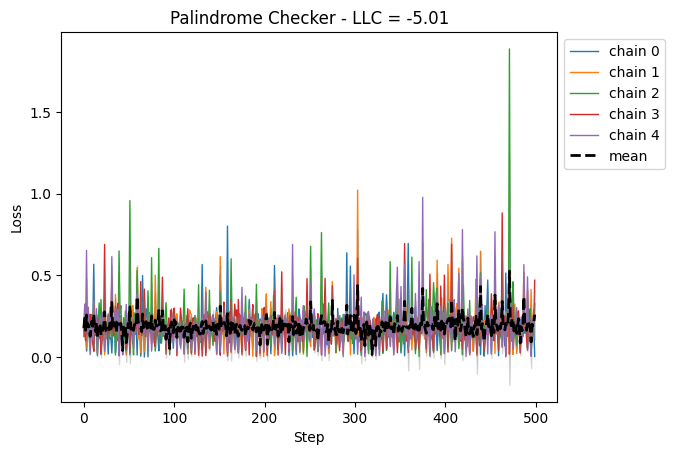

<Figure size 1200x900 with 0 Axes>


NEXT STEPS FOR YOUR RESEARCH
1. Compile different algorithms (sorting, counting, etc.)
2. Vary model size (vocab size, sequence length)
3. Compare LLCs across algorithms
4. Relate LLC to algorithmic complexity metrics


In [11]:
from tracr.rasp import rasp
from tracr.compiler import compiling
from tracr.haiku_to_pytorch import haiku_to_pytorch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# ============================================================================
# PALINDROME RASP PROGRAM
# ============================================================================

def is_palindrome_numerical(tokens):
    """
    Returns a numerical value per position:
    - 1.0 if that position matches its reverse position
    - 0.0 if it doesn't match
    """
    all_true_selector = rasp.Select(tokens, tokens, rasp.Comparison.TRUE)
    length = rasp.SelectorWidth(all_true_selector)

    opp_idx = (length - rasp.indices).named("opp_idx")
    opp_idx = (opp_idx - 1).named("opp_idx-1")
    reverse_selector = rasp.Select(rasp.indices, opp_idx, rasp.Comparison.EQ)
    reverse = rasp.Aggregate(reverse_selector, tokens)

    check = rasp.SequenceMap(lambda x, y: x == y, tokens, reverse)
    check_numerical = rasp.Map(lambda b: 1.0 if b else 0.0, check)
    check_numerical = rasp.numerical(check_numerical)
    
    return check_numerical


def compile_palindrome_model():
    """Compile the palindrome checker to a transformer model."""
    bos = "BOS"
    vocab = {'a', 'b', 'c', 'd', 'e'}
    max_seq_len = 5
    
    model = compiling.compile_rasp_to_model(
        program=is_palindrome_numerical(rasp.tokens),
        vocab=vocab,
        max_seq_len=max_seq_len,
        compiler_bos=bos,
    )
    
    return model, vocab, max_seq_len, bos


# ============================================================================
# PURE PYTORCH COMPILED MODEL
# ============================================================================

class CompiledPalindromeModel(nn.Module):
    """
    Pure PyTorch version of the compiled TRACR model.
    This is the FULL compiled algorithm as a neural network.
    We'll estimate LLC on this entire model.
    """
    def __init__(self, base_model, vocab_size, d_model, max_pos, token_to_idx, haiku_model):
        super().__init__()
        self.token_to_idx = token_to_idx
        self.vocab_size = vocab_size
        self.d_model = d_model
        
        # Embeddings (with compiled weights)
        self.token_embed = nn.Embedding(vocab_size, d_model, dtype=torch.float64)
        self.pos_embed = nn.Embedding(max_pos, d_model, dtype=torch.float64)
        
        # Copy compiled weights from Haiku model
        with torch.no_grad():
            token_emb_weights = torch.tensor(
                np.array(haiku_model.params['token_embed']['embeddings']),
                dtype=torch.float64
            )
            self.token_embed.weight.copy_(token_emb_weights)
            
            pos_emb_weights = torch.tensor(
                np.array(haiku_model.params['pos_embed']['embeddings']),
                dtype=torch.float64
            )
            self.pos_embed.weight.copy_(pos_emb_weights)
        
        # Transformer layers (compiled)
        self.layers = nn.ModuleList(base_model.layers)
        
        # We need SOME way to convert TRACR output to class labels
        # Since TRACR outputs per-position checks in the residual stream,
        # we need a minimal readout layer
        # Keep this VERY simple so LLC mostly measures the compiled algorithm
        self.readout = nn.Linear(d_model, 2, dtype=torch.float64)
        
        # Initialize readout to be nearly identity-like
        with torch.no_grad():
            self.readout.weight.normal_(0, 0.01)
            self.readout.bias.zero_()
    
    def forward(self, x):
        """
        x: List of sequences (each sequence is a list of token strings)
        Returns: logits for [not-palindrome, palindrome]
        """
        # Convert token strings to indices
        batch_indices = []
        for seq in x:
            indices = [self.token_to_idx[token] for token in seq]
            batch_indices.append(indices)
        
        x_indices = torch.tensor(batch_indices, dtype=torch.long, device=self.token_embed.weight.device)
        
        # Embed (using compiled embeddings)
        tok_emb = self.token_embed(x_indices)
        pos_emb = self.pos_embed(torch.arange(x_indices.shape[1], device=x_indices.device))
        x = tok_emb + pos_emb
        
        # Pass through compiled transformer layers
        for layer in self.layers:
            x = layer(x)
        
        # Simple readout: average pool and project to 2 classes
        pooled = x.mean(dim=1)  # (batch, d_model)
        logits = self.readout(pooled)  # (batch, 2)
        
        return logits


# ============================================================================
# DATASET
# ============================================================================

class PalindromeDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, seq_len, num_samples, bos="BOS"):
        self.vocab = list(vocab)
        self.seq_len = seq_len
        self.num_samples = num_samples
        self.bos = bos
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        seq = [np.random.choice(self.vocab) for _ in range(self.seq_len)]
        is_palindrome = (seq == seq[::-1])
        label = 1 if is_palindrome else 0
        full_seq = [self.bos] + seq
        return full_seq, label


def custom_collate(batch):
    sequences, labels = zip(*batch)
    return list(sequences), torch.tensor(labels, dtype=torch.long)


# ============================================================================
# EVALUATION FUNCTION
# ============================================================================

def evaluate(model, batch):
    """
    Evaluation function for LLC estimation.
    Returns (loss, dict) as expected by devinterp.
    """
    sequences, labels = batch
    labels = labels.to(DEVICE)
    
    logits = model(sequences)
    loss = F.cross_entropy(logits, labels, reduction='mean')
    
    return loss, {"logits": logits}


# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Compile TRACR model
    print("="*70)
    print("COMPILING RASP PALINDROME PROGRAM TO TRANSFORMER")
    print("="*70)
    init_model, vocab, max_seq_len, bos = compile_palindrome_model()
    base_model = haiku_to_pytorch(init_model)
    
    # Extract model info
    token_to_idx = init_model.input_encoder.encoding_map
    vocab_size = init_model.input_encoder.vocab_size
    d_model = base_model.layers[0].attn.d_model
    max_pos = init_model.params['pos_embed']['embeddings'].shape[0]
    num_layers = len(base_model.layers)
    
    print(f"\nCompiled Model Architecture:")
    print(f"  Vocab size: {vocab_size}")
    print(f"  Model dimension: {d_model}")
    print(f"  Max positions: {max_pos}")
    print(f"  Number of layers: {num_layers}")
    
    # Create pure PyTorch model with compiled TRACR weights
    model = CompiledPalindromeModel(
        base_model, vocab_size, d_model, max_pos, token_to_idx, init_model
    ).to(DEVICE)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"  Total parameters: {total_params:,}")
    
    # Create dataset
    print("\n" + "="*70)
    print("CREATING EVALUATION DATASET")
    print("="*70)
    dataset = PalindromeDataset(vocab, max_seq_len, num_samples=10000, bos=bos)
    loader = torch.utils.data.DataLoader(
        dataset, 
        batch_size=256, 
        shuffle=True, 
        collate_fn=custom_collate
    )
    
    # Quick training of ONLY the readout layer to make it functional
    # This is minimal - just enough to convert TRACR features to labels
    print("\n" + "="*70)
    print("TRAINING MINIMAL READOUT LAYER")
    print("="*70)
    
    # Freeze everything except readout
    for param in model.token_embed.parameters():
        param.requires_grad = False
    for param in model.pos_embed.parameters():
        param.requires_grad = False
    for param in model.layers.parameters():
        param.requires_grad = False
    # Readout stays trainable
    
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Training only readout layer: {trainable_params:,} parameters")
    
    optimizer = torch.optim.Adam(model.readout.parameters(), lr=1e-3)
    
    model.train()
    for epoch in range(10):
        correct = 0
        total = 0
        total_loss = 0
        
        for batch in loader:
            sequences, labels = batch
            labels = labels.to(DEVICE)
            
            optimizer.zero_grad()
            logits = model(sequences)
            loss = F.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()
            
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += len(labels)
            total_loss += loss.item()
        
        acc = correct / total
        avg_loss = total_loss / len(loader)
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Acc={acc:.4f}")
        
        if acc > 0.95:
            print(f"Readout converged at epoch {epoch+1}")
            break
    
    # Verify accuracy
    print("\n" + "="*70)
    print("VERIFYING MODEL ACCURACY")
    print("="*70)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            sequences, labels = batch
            labels = labels.to(DEVICE)
            logits = model(sequences)
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += len(labels)
    
    final_accuracy = correct / total
    print(f"Final model accuracy: {final_accuracy:.4f} ({correct}/{total})")
    
    if final_accuracy < 0.90:
        print("\nWARNING: Model accuracy is low!")
        print("LLC estimation may not be meaningful.")
        print("Consider debugging the model architecture.")
    
    # NOW: Make ENTIRE model trainable and estimate LLC
    print("\n" + "="*70)
    print("ESTIMATING LLC ON FULL COMPILED MODEL")
    print("="*70)
    
    # Make everything trainable for LLC estimation
    for param in model.parameters():
        param.requires_grad = True
    
    total_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Estimating LLC over all {total_trainable:,} parameters")
    print(f"This includes:")
    print(f"  - Embeddings: {sum(p.numel() for p in model.token_embed.parameters()) + sum(p.numel() for p in model.pos_embed.parameters()):,}")
    print(f"  - Transformer layers: {sum(p.numel() for p in model.layers.parameters()):,}")
    print(f"  - Readout: {sum(p.numel() for p in model.readout.parameters()):,}")
    
    # ============================================================================
    # DEBUGGING SECTION
    # ============================================================================
    print("\n" + "="*70)
    print("PRE-LLC DEBUGGING")
    print("="*70)

    # 1. Check loss values
    model.eval()
    losses = []
    with torch.no_grad():
        for batch in loader:
            loss, _ = evaluate(model, batch)
            losses.append(loss.item())

    mean_loss = np.mean(losses)
    std_loss = np.std(losses)

    print(f"\nLoss statistics:")
    print(f"  Mean loss: {mean_loss:.6f}")
    print(f"  Std loss: {std_loss:.6f}")
    print(f"  Min loss: {np.min(losses):.6f}")
    print(f"  Max loss: {np.max(losses):.6f}")

    if mean_loss < 0.01:
        print("\n⚠️  WARNING: Loss is very close to zero!")
        print("   The model may be too deterministic for LLC estimation.")
        print("   Consider adding noise or using a harder task.")

    # 2. Check gradient magnitudes
    model.train()
    batch = next(iter(loader))
    loss, _ = evaluate(model, batch)
    loss.backward()

    grad_norms = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norms.append(param.grad.norm().item())

    print(f"\nGradient statistics:")
    print(f"  Mean grad norm: {np.mean(grad_norms):.6e}")
    print(f"  Max grad norm: {np.max(grad_norms):.6e}")
    print(f"  Min grad norm: {np.min(grad_norms):.6e}")

    # 3. Check parameter scale
    param_norms = [p.norm().item() for p in model.parameters()]
    print(f"\nParameter statistics:")
    print(f"  Mean param norm: {np.mean(param_norms):.6e}")
    print(f"  Max param norm: {np.max(param_norms):.6e}")

    # 4. Test SGLD sampler manually
    print("\nTesting SGLD sampler...")
    from devinterp.optim import SGLD

    test_optimizer = SGLD(
        model.parameters(),
        lr=1e-4,
        localization=10.0,
        nbeta=default_nbeta(loader)
    )

    initial_loss = loss.item()
    print(f"  Initial loss: {initial_loss:.6f}")

    # Take a few SGLD steps
    for step in range(10):
        batch = next(iter(loader))
        test_optimizer.zero_grad()
        loss, _ = evaluate(model, batch)
        loss.backward()
        test_optimizer.step()
        if step % 3 == 0:
            print(f"  Step {step}: loss = {loss.item():.6f}")

    print("\n" + "="*70)
    
    # ============================================================================
    # LLC ESTIMATION
    # ============================================================================
    model.train()
    
    print("\nRunning SGLD sampling...")
    print("This may take several minutes...")
    
    learning_coeff_stats = estimate_learning_coeff_with_summary(
        model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=SGLD,
        optimizer_kwargs=dict(
            lr=1e-6,
            localization=1.0,
            nbeta=default_nbeta(loader)
        ),
        num_chains=5,
        num_draws=500,
        num_burnin_steps=200,
        num_steps_bw_draws=10,
        device=DEVICE,
        online=True,
    )
    
    # Results
    print("\n" + "="*70)
    print("LLC ESTIMATION RESULTS")
    print("="*70)
    llc_means = learning_coeff_stats['llc/means']
    llc_avg = np.mean(llc_means)
    llc_std = np.std(llc_means)
    
    print(f"\nLLC per chain: {[f'{x:.2f}' for x in llc_means]}")
    print(f"Average LLC: {llc_avg:.2f}")
    print(f"Std across chains: {llc_std:.2f}")
    print(f"\nModel has {total_trainable:,} parameters")
    print(f"Effective dimension (LLC) is ~{llc_avg:.0f}")
    print(f"Compression ratio: {llc_avg/total_trainable:.4f}")
    
    # For your research questions:
    print("\n" + "="*70)
    print("RESEARCH NOTES")
    print("="*70)
    print(f"Algorithm: Palindrome checker")
    print(f"Model size: {total_trainable:,} parameters")
    print(f"Architecture: {num_layers} layers, d_model={d_model}")
    print(f"LLC: {llc_avg:.2f} ± {llc_std:.2f}")
    print(f"Accuracy: {final_accuracy:.4f}")
    
    # Plot
    plot_trace(
        learning_coeff_stats["loss/trace"],
        "Loss",
        x_axis="Step",
        title=f"Palindrome Checker - LLC = {llc_avg:.2f}",
        plot_mean=False,
        plot_std=False,
        fig_size=(12, 9),
        true_lc=None,
    )
    
    print("\n" + "="*70)
    print("NEXT STEPS FOR YOUR RESEARCH")
    print("="*70)
    print("1. Compile different algorithms (sorting, counting, etc.)")
    print("2. Vary model size (vocab size, sequence length)")
    print("3. Compare LLCs across algorithms")
    print("4. Relate LLC to algorithmic complexity metrics")